In [8]:
import os
import struct
import matplotlib
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import sys
import pymongo
%matplotlib inline

In [2]:
class channel(object):
    def __init__(self,edfFile,label=None,transducer=None,dimensions=None,
                physMin=None,physMax=None,digMin=None,digMax=None,
                 preFilter=None,sampleRate=None,notes=None,channelIndex=None,byteLength=None):
        self.edfFile = edfFile
        self.label = str(label)
        self.sampleRate = int(sampleRate)
        self.transducer = str(transducer)
        self.dimensions = dimensions
        self.physMin = physMin
        self.physMax = physMax
        self.digMin = digMin
        self.digMax = digMax
        self.preFilter = preFilter
        self.notes  = notes
        self.channelIndex = int(channelIndex)
        self.byteLength = byteLength
        #self.indexStart = indexStart
    
    def __str__(self):
        if self.label==None:
            return "None"
        else:
            returnString = ("Label: "+str(self.label) + "\nSample Rate"+str(self.sampleRate)+
            "\nTransducer: "+str(self.transducer)+"\nDimensions: "+str(self.dimensions)+
            "\nphysMin: "+str(self.physMin)+"\nphysMax: "+str(self.physMax)+
            "\ndigMin: "+str(self.digMin) +"\ndigMax: "+str(self.digMax)+ "\npreFilter: "+str(self.preFilter)+
            "\nNotes: "+str(self.notes) + "\nChannelIndex: "+str(self.channelIndex) + "\nbyteLength: "+str(self.byteLength))
        return returnString
    
    def channelData(self,start,duration,channelNumber = 0,sensitivity = 1):
        '''
        Returns data points for desired area
        start: seconds from start of record
        duration: time  of record desired in seconds
        ##########This might be easier to do within original edf class
        '''
        toReturn = []
        startByte = start * self.sampleRate * 2
        seekLocation = int(self.channelIndex + startByte)  #need to fix this
        numberOfBytes = int(self.sampleRate) * duration # * 2
        self.edfFile.edfRawData.seek(seekLocation)
        for i in range(numberOfBytes):
            value = struct.unpack('h',self.edfFile.edfRawData.read(2))[0]
            value = np.array(value)*sensitivity
            value -= channelNumber*20*sensitivity
            toReturn.append(value)
            #toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2))) 
        return toReturn

    def allChannelData(self):
        toReturn = []
        self.edfFile.edfRawData.seek(self.channelIndex)
        for i in range(int(self.byteLength/2)):
            toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2)))
        return toReturn
        
    def getLabel(self):
        return str(self.label)
    
    def getSampleRate(self):
        return self.sampleRate
    
    def getChannelIndex(self):
        return self.channelIndex
    
    def getTransducer(self):
        return self.transducer

    def getDimensions(self):
        return self.dimensions
    
    def getPhysMin(self):
        return self.physMin
    
    def getPhysMax(self):
        return self.physMax
    
    def getDigMin(self):
        return self.digMin
    
    def getDigMax(self):
        return self.digMax
    
    def getPreFilter(self):
        return self.preFilter
    
    def getNotes(self):
        return self.notes
    
    def getByteLength(self):
        return self.byteLength

In [3]:
class edfData(object):
    def __init__(self,fileId):
        self.fileId=fileId
        
    def __str__(self):
        return ("version: " + str(self.version) + "\nPatient Id: "+str(self.patientId) 
                + "\nrecordId" + str(self.recordId) + "\nStart Date: " + str(self.startTime)
                + "\nStart Time: " + str(self.startTime)
                + "\nheader Bytes: " + str(self.headerBytes) +"\nReserve Bytes: " +str(self.reservedBytes)
                + "\nNum Records :" + str(self.nRecords) + "\nNum Signals :" + str(self.nSignals) 
                + "\nDuration: "+ str(self.duration) + "\nFile Size: "+str(self.fileSize))
                
                
    def loadFile(self,filepath):
        self.filePath = filepath
        self.fileSize = os.path.getsize(filepath)
        self.edfRawData = open(filepath,'rb')
        
    def readBitsTest(self):
        self.edfRawData.seek(0)
        bits = self.edfRawData.read(10000)
        self.edfRawData.seek(0)
        print(self.edfRawData.read(10))
        print("Some Bits: "+str(bits))
        return bits
    
    def readSignalHeaderBits(self,bitsIn,nSignals,nBits):
            returnArray = []
            for x in range(nSignals):
                returnArray.append(bitsIn.read(nBits))
            return returnArray
    
    def parseEdf(self):
        '''
            This function parses the edf file getting the values of 
            the header fields. It also creates a channel object with 
            information about each channel, including the eeg tracing data from each channel.
        '''
        #Header Fields
        self.version = str(self.edfRawData.read(8))
        self.patientId = str(self.edfRawData.read(80))
        self.recordId = str(self.edfRawData.read(80))
        self.startDate = str(self.edfRawData.read(8))
        self.startTime = str(self.edfRawData.read(8))
        self.headerBytes = int(self.edfRawData.read(8))
        self.reservedBytes = str(self.edfRawData.read(44))
        self.nRecords = int(self.edfRawData.read(8))
        self.duration = float(self.edfRawData.read(8))
        self.nSignals = int(self.edfRawData.read(4))
        
        #Create channel object for each channel
        self.channels = {}
        channelFields = ['labels','transducer','dimensions','physMin','physMax','digMin','digMax',
                        'preFilter','sampleRate','reservedNotes']
        self.channels['labels'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,16)
        self.channels['transducer'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['dimensions'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['preFilter'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['sampleRate'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['reservedNotes'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,32)
        
        self.channelObjects = []
        self.sampleRate = self.channels['sampleRate'][0]
        channelDataStart = self.headerBytes
        
        #This loop creates and add channel objects to self.channelObjects
        for i in range(int(self.nSignals)):
            
            channelValues ={'filepath':self.filePath}
            byteLength = int(self.channels['sampleRate'][i])*self.nRecords*2
            channelIndex = channelDataStart
            channelDataStart +=byteLength
            
            for j in channelFields:
                try:
                    channelValues[j]=(self.channels[j][i])
                except:
                    channelValues[j] = None
            self.channelObjects.append(
                channel(self,channelValues['labels'],channelValues['transducer'],
                        channelValues['dimensions'],channelValues['physMin'],channelValues['physMax'],
                        channelValues['digMin'],channelValues['digMax'],channelValues['preFilter'],
                        channelValues['sampleRate'],channelValues['reservedNotes'],
                        channelIndex,byteLength))
            
    def data(self,start,duration):
        sampleData = []
        j = 0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration)])
            j+=1
        return sampleData
    
    def dataForGraph(self,start,duration,sensitivity=1):
        sampleData = []
        j=0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration,j,sensitivity)])
            j+=1
        return sampleData
    
    def allData(self):
        '''
        Return[sampleRate,{channelData}]
        '''
        channelData = {}
        for x in self.channelObjects:
            channelData[str(x.getLabel())]=np.array(x.allChannelData())
        return[int(self.sampleRate),channelData]
            
            
    
    def patientId(self):
        return self.patientId
    
    def recordId(self):
        return self.recordId
    
    def startDate(self):
        return self.startDate
    
    def startTime(self):
        return self.startTime
    
    def headerBytes(self):
        return self.headerBytes
    
    def reservedBytes(self):
        return self.reservedBytes
    
    def duration(self):
        return self.duration
    
    def nRecords(self):
        return self.nRecords
    
    def numSignals(self):
        return self.nSignals
    
    def sampleRate(self):
        return self.sampleRate

    def channelLabels(self):
        labels = []
        for channel in self.channelObjects:
            labels.append(channel.label())
        return labels
    
    def totalSamples(self):
        duration = int(self.sampleRate) * int(self.nRecords)
        return duration
    
    def testChannelPrint(self):
        print(self.channelObjects[2])

In [4]:
edfFile1 = edfData(1)
edfFile1.loadFile("v1.2.0/eval/01_tcp_ar/00000258/s002_2003_07_21/00000258_s002_t000.edf")
edfFile1.parseEdf()

edfFile2 = edfData(1)
edfFile2.loadFile("v1.2.0/eval/01_tcp_ar/00001027/s003_2004_01_29/00001027_s003_t000.edf")
edfFile2.parseEdf()

print(edfFile2)
#edfFile1.readBitsTest()
print("\n")
print(edfFile2.channelObjects[0])
print("\n")
print(edfFile2.channelObjects[1])
print("\n")
print(edfFile2.channelObjects[2])
print("\n")
print(edfFile2.channelObjects[30])



version: b'0       '
Patient Id: b'00001027                                                                        '
recordIdb'Startdate 29-JAN-2004 00001027_s003                                             '
Start Date: b'17.54.09'
Start Time: b'17.54.09'
header Bytes: 8448
Reserve Bytes: b'EDF                                         '
Num Records :464
Num Signals :32
Duration: 1.0
File Size: 11886848


Label: b'EEG FP1-REF     '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin: b'-29483.1'
physMax: b'29483.12'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:-1.000 Hz LP:-2.0 Hz N:0.0                                                   '
Notes: b'                                '
ChannelIndex: 8448
byteLength: 371200


Label: b'EEG FP2-REF     '
Sample Rate400
Transducer: b'EEG                                                                             '
Dimensions: b'uV      '
physMin:

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


b'EEG FP1-REF     '
b'EEG FP1-REF     '
b'EEG FP1-REF     '
b'EEG FP1-REF     '
8448
8448
8448
8448


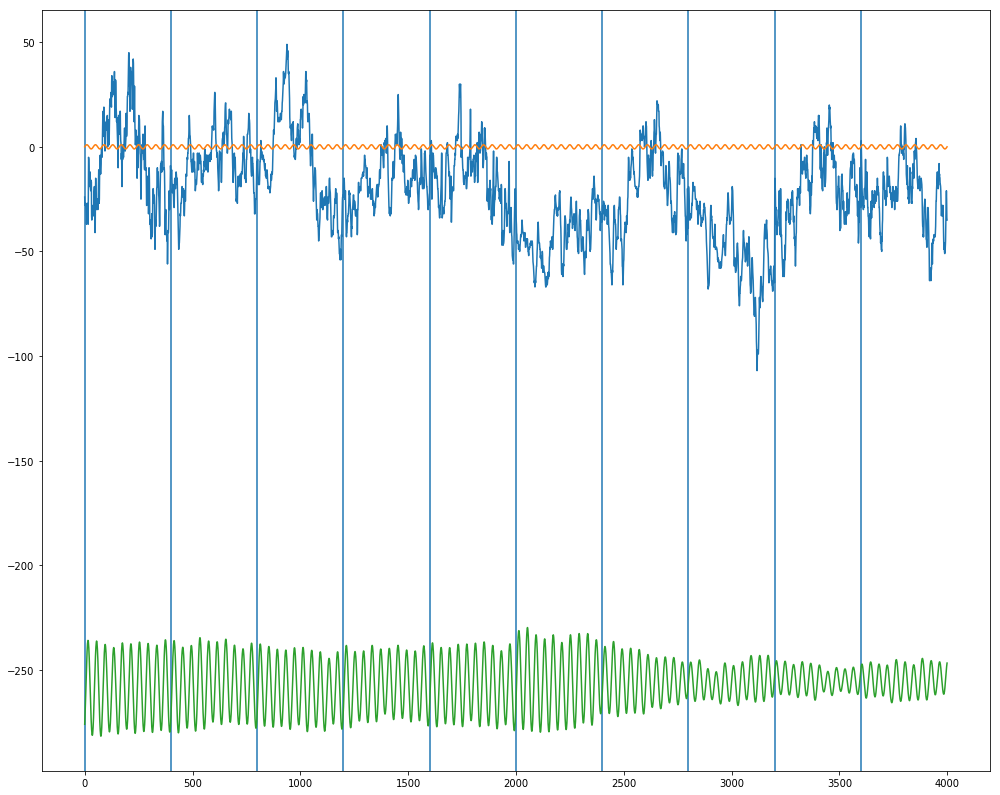

In [5]:
channelObj = edfFile2.channelObjects[0]
sampleDuration = 10
sampleRate = int(channelObj.sampleRate)
totalSamples = sampleDuration*sampleRate
channelData = channelObj.channelData(0,sampleDuration,1)

channel2 = edfFile2.channelObjects[0]
channel2Data = channel2.channelData(1,sampleDuration,6)

channel3 = edfFile2.channelObjects[0]
channel3Data = channel3.channelData(2,sampleDuration,12)

channel4 = edfFile2.channelObjects[0]
channel4Data = channel4.channelData(3,sampleDuration,18)

channel5Data = ((np.array(channel4Data) - np.array(channel3Data))-500)

allChannelData = np.array(channelObj.allChannelData())
chanData1 = allChannelData[0:4000] - 256
chanData2 = allChannelData[400:4400] - 512
plt.figure(figsize=(17,14))
plt.plot(channelData)
#plt.plot(chanData1)
#plt.plot(chanData2)
#plt.plot(channel2Data)
#plt.plot(channel3Data)
#plt.plot(channel4Data)
#plt.plot(channel5Data)

for x in range(0,sampleDuration):
    plt.axes().axvline(x*sampleRate,0,1).set_label(x)
    
x = np.linspace(0, totalSamples,totalSamples)
sinWave = np.sin(x/sampleRate*np.pi*10*2)

con1 = signal.convolve(channelData,sinWave,"same")
con1 = np.array(con1)*0.01-256
plt.plot(sinWave)
plt.plot(con1)
print (channelObj.label)
print (channel2.label)
print (channel3.label)
print (channel4.label)
print (channelObj.channelIndex)
print (channel2.channelIndex)
print (channel3.channelIndex)
print (channel4.channelIndex)

b'EEG O2-REF      '
Sample Rate: 400


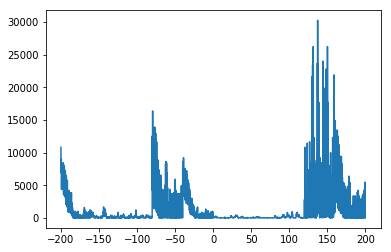

In [6]:
#edfFile2 channelObjects
#periodagram test

channel1 = edfFile2.channelObjects[9]
channel1Data = np.array(channel1.allChannelData())
channelDataTest = channel1Data[0:4000]
sampleRate = int(channel1.getSampleRate())
print(channel1.getLabel())
print("Sample Rate: " + str(sampleRate))

#fft Power Spectra
powerSpectra = np.abs(np.fft.fft(channelDataTest))**2
timestep = 1/sampleRate
freqs = np.fft.fftfreq(channelDataTest.size,timestep)
idx = np.argsort(freqs)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(freqs[idx], powerSpectra[idx])

##Welch power spectra
#f,pxx_den = signal.welch(x,400)
#fig2 = plt.figure()
#ax2 = fig2.add_subplot(111)



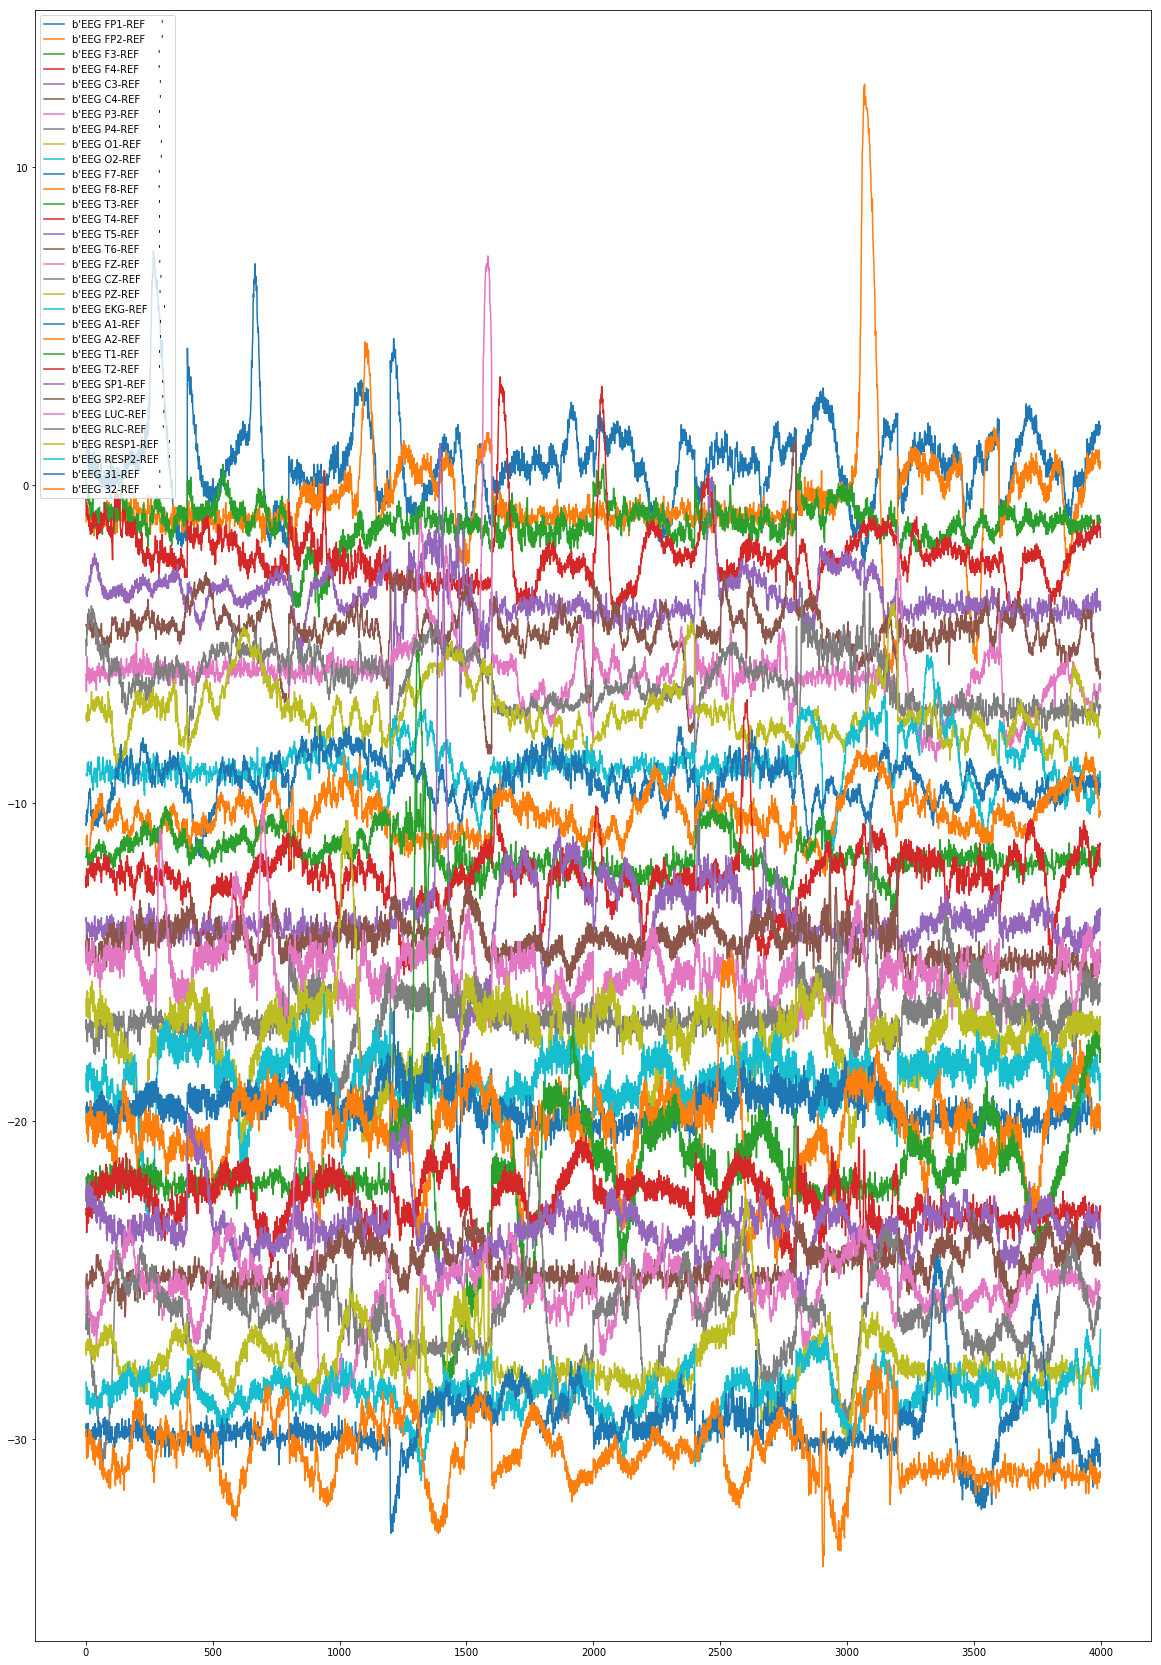

In [7]:
plotData = edfFile1.dataForGraph(0,10,0.05)
plt.figure(figsize=(20,30))
for x in plotData:
    plt.plot(x[1],label=x[0])
plt.legend()